# KI

In [187]:
%matplotlib inline
# Import modules

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphviz
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, matthews_corrcoef,\
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Local modules
import constantes
import auxiliary
import models
import plots

In [188]:
seed = 42  # random seed for reproductibility

# Selected phenotype
type = "cd3"
condition = "ki"
sess = f"{type}_{condition}"  # session condition

In [189]:
data_dirpath = auxiliary.to_dirpath(constantes.DATA_DIR)
out_dirpath = auxiliary.to_dirpath(constantes.OUTPUT_DIR)

# create path to {sess} output directory
sess_dirpath = auxiliary.create_dir(f"{out_dirpath}{sess}")
sess_perf_dirpath = auxiliary.create_dir(f"{sess_dirpath}{'performances'}")
sess_tree_dirpath = auxiliary.create_dir(f"{sess_dirpath}{'tree'}")
sess_imp_dirpath = auxiliary.create_dir(f"{sess_dirpath}{'importances'}")

In [190]:
# Used dataset
data_frame = auxiliary.read_dataframe(
    filepath=f"{data_dirpath}{'WT_KI_CD3_in-tumor'}.csv",
    index_col=0
)

# Data first values
data_frame.head()

Condition                                 FileName     X    Y  \
107048        WT  ./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif  4987  625   
107205        WT  ./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif  4867  665   
107206        WT  ./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif  4907  665   
107207        WT  ./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif  4947  665   
107208        WT  ./12c_ZF_ MAX_12c_MW137_CD3FITC_SHG.tif  4987  665   

        Coherency100  Energy100  MeanInt100  VarInt100  Density100  \
107048          -3.0       -3.0        -3.0       -3.0         0.0   
107205          -3.0       -3.0        -3.0       -3.0         0.0   
107206          -3.0       -3.0        -3.0       -3.0         0.0   
107207          -3.0       -3.0        -3.0       -3.0         0.0   
107208          -3.0       -3.0        -3.0       -3.0         0.0   

        VarDensity100  ...  Cells100um  MinDist100um  MedDist100um  \
107048           -3.0  ...         0.0           0.0           0.0   
107205           -3.0  ...         0.0           0.0           0.0   
107206           -3.0  ...         0.0           0.0           0.0   
107207           -3.0  ...         0.0           0.0           0.0   
107208           -3.0  ...         0.0           0.0           0.0   

        CellArea100um  CellEcc100um  Frac  class_t_plus  class_t_enriched  \
107048            0.0           0.0   NaN             0                 0   
107205            0.0           0.0   NaN             0                 0   
107206            0.0           0.0   NaN             0                 0   
107207            0.0           0.0   NaN             0                 0   
107208            0.0           0.0   NaN             0                 0   

        class_t_enriched_2  class_density  
107048                   0              0  
107205                   0              0  
107206                   0              0  
107207                   0              0  
107208                   0              0  

[5 rows x 54 columns]

In [191]:
# Mask for the studied phenotype
MASK_TYPE = data_frame["Type"] == type.upper()
MASK_COND = data_frame["Condition"] == condition.upper()

In [192]:
# Main data with selected phenotype
data = data_frame[MASK_TYPE & MASK_COND]

In [193]:
# Column features (without Dist & Angle information)
x_columns = [
    *constantes.float20_columns_unloc,
    *constantes.float60_columns_unloc,
    *constantes.float100_columns_unloc,
    *constantes.float140_columns_unloc
]

# Features columns with Dist & Angle attributes
x_loc_columns = [
    *constantes.float20_columns,
    *constantes.float60_columns,
    *constantes.float100_columns,
    *constantes.float140_columns,
    *constantes.dist_columns
]

# T plus

Prédiction des fenêtres de classe T+

In [194]:
# Respective directory for the designed class
plus_perf_dirpath = auxiliary.create_dir(f"{sess_perf_dirpath}{'plus'}")
plus_tree_dirpath = auxiliary.create_dir(f"{sess_tree_dirpath}{'plus'}")
plus_imp_dirpath = auxiliary.create_dir(f"{sess_imp_dirpath}{'plus'}")

### Jeu de données d'apprentissage et de validation (avec valeurs abérrantes)

In [195]:
# Target column
y_column = "class_t_plus"

# Define x and y dataframe
xy = data[x_loc_columns + [y_column]].dropna()

# features
x = xy[x_columns].values
x_loc = xy[x_loc_columns].values  # with distance/angle

# target value
y = xy[y_column].values

## Train and Validation
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=seed, stratify=y
)

# With (Angle & Dist)
x_loc_train, x_loc_test, y_loc_train, y_loc_test = train_test_split(
    x_loc, y, test_size=0.3, random_state=seed, stratify=y
)

In [196]:
print(f"----- T plus -----")
print(f"\n{'Comptage des classes :':<30s}{'0':<6s}{'':2s}{'1':>6s}")
print(f"{'y:':30s}{sum(y == 0):>6d}{'':2s}{sum(y == 1):>6d}")
print(f"{'y_train:':30s}{sum(y_train == 0):>6d}{'':2s}{sum(y_train == 1):>6d}")
print(f"{'y_test:':30s}{sum(y_test == 0):>6d}{'':2s}{sum(y_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y.shape[0]:_}")

----- T plus -----

Comptage des classes :        0            1
y:                            304962  792136
y_train:                      213473  554495
y_test:                        91489  237641

Nombre d'observations totales : 1_097_098


#### Arbre de décision

In [197]:
depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Results with best selected depth
results_t_plus = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced"
)

# Results with best selected depth (with Dist & Angle)
results_loc_t_plus = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced"
)

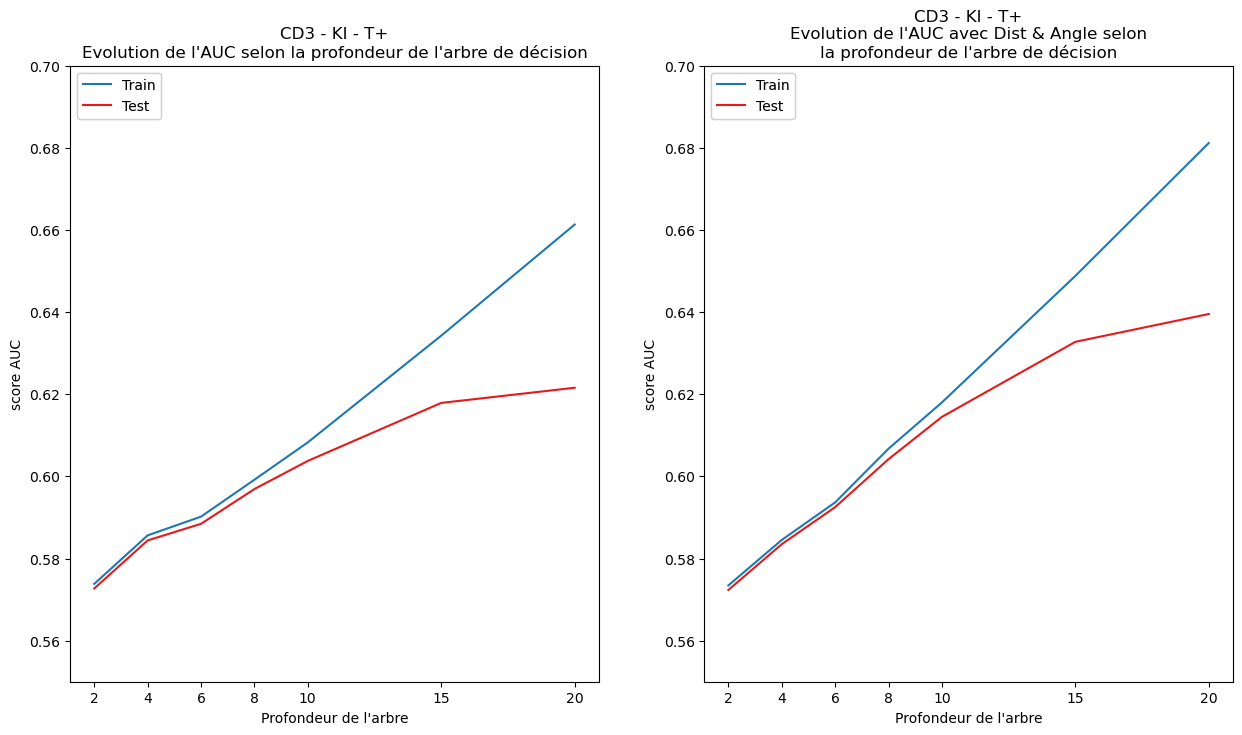

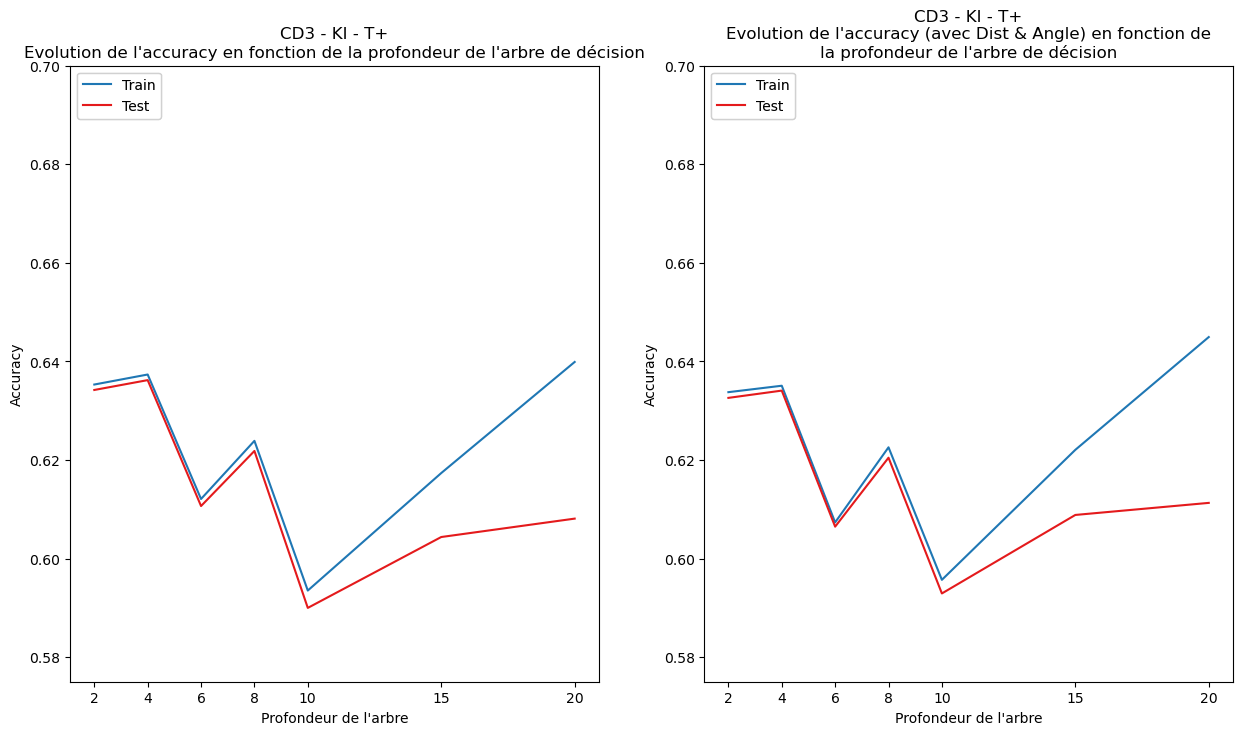

In [198]:
# Plot - AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_t_plus["auc_train"],
    results_t_plus["auc_test"],
    indices=results_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.55, ytop=0.7, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_plus["auc_train"],
    results_loc_t_plus["auc_test"],
    indices=results_loc_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'AUC avec Dist & Angle selon\n"
          "la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.55, ytop=0.7, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_auc-decisiontree")

# Showing plot
plt.show()

# Plot - Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_plus["acc_train"],
    results_t_plus["acc_test"],
    indices=results_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'accuracy en fonction de la "
          "profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.575, ytop=0.7, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_plus["acc_train"],
    results_loc_t_plus["acc_test"],
    indices=results_loc_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'accuracy (avec Dist & Angle) en "
          "fonction de\nla profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.575, ytop=0.7, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_accuracy-decisiontree")

# Showing plot
plt.show()

In [199]:
print("----- Résumé des performances en classe T plus, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_plus["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["acc_test"]] ; print("\n")
print(f"{'MCC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["mcc_train"]] ; print()
print(f"{'MCC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus["mcc_test"]] ; print("\n")

print("--- with Dist & Angle")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus["acc_test"]] ; print("\n")
print(f"{'MCC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus["mcc_train"]] ; print()
print(f"{'MCC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus["mcc_test"]] ; print()

----- Résumé des performances en classe T plus, arbre de décision -----
Profondeur          : 2     4     6     8     10    15    20    

AUC_train           : 0.57  0.59  0.59  0.60  0.61  0.63  0.66  
AUC_test            : 0.57  0.58  0.59  0.60  0.60  0.62  0.62  

Accuracy_train      : 0.64  0.64  0.61  0.62  0.59  0.62  0.64  
Accuracy_test       : 0.63  0.64  0.61  0.62  0.59  0.60  0.61  

MCC_train           : 0.14  0.16  0.16  0.18  0.19  0.24  0.29  
MCC_test            : 0.14  0.16  0.16  0.18  0.19  0.21  0.22  

--- with Dist & Angle
AUC_train_dist      : 0.57  0.58  0.59  0.61  0.62  0.65  0.68  
AUC_test_dist       : 0.57  0.58  0.59  0.60  0.61  0.63  0.64  

Accuracy_train_dist : 0.63  0.64  0.61  0.62  0.60  0.62  0.64  
Accuracy_test_dist  : 0.63  0.63  0.61  0.62  0.59  0.61  0.61  

MCC_train_dist      : 0.14  0.16  0.17  0.19  0.21  0.27  0.32  
MCC_test_dist       : 0.14  0.16  0.17  0.19  0.21  0.24  0.25  


In [200]:
# TODO: Save auc, accuracy, mcc values to performances directory

In [201]:
# Decision Tree (CART)
dtree_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced"
)

# Decision Tree (CART) with Dist column
dtree_loc_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced"
)

In [202]:
# Fitting models on data
dtree_plus.fit(x_train, y_train)
dtree_loc_plus.fit(x_loc_train, y_loc_train)

# Prediction on train and validation
y_train_pred = dtree_plus.predict(x_train)
y_test_pred = dtree_plus.predict(x_test)

y_loc_train_pred = dtree_loc_plus.predict(x_loc_train)
y_loc_test_pred = dtree_loc_plus.predict(x_loc_test)

# Labels (for re-assignment)
dtree_plus.classes_ = \
dtree_loc_plus.classes_ = \
labels_class_plus = pd.Series(dtree_plus.classes_).map(
    {0: 'not_plus', 1: 'plus'}
).values

In [203]:
# ROC values - false positive rate (fpr), and true positive rate (tpr)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

# Model performances, how often is the classifier correct?
# train
acc_train = accuracy_score(y_train, y_train_pred)
mcc_train = matthews_corrcoef(y_train, y_train_pred)
auc_train = auc(fpr_train, tpr_train)
# test
acc_test = accuracy_score(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
auc_test = auc(fpr_test, tpr_test)

# with dist & angle
# train
acc_loc_train = accuracy_score(y_loc_train, y_loc_train_pred)
mcc_loc_train = matthews_corrcoef(y_loc_train, y_loc_train_pred)
auc_loc_train = auc(fpr_loc_train, tpr_loc_train)
# test
acc_loc_test = accuracy_score(y_loc_test, y_loc_test_pred)
mcc_loc_test = matthews_corrcoef(y_loc_test, y_loc_test_pred)
auc_loc_test = auc(fpr_loc_test, tpr_loc_test)

----- Arbre de décision T+ -----
Train
Accuracy   = 0.607
AUC        = 0.617
MCC        = 0.209

Test
Accuracy   = 0.602
AUC        = 0.611
MCC        = 0.199


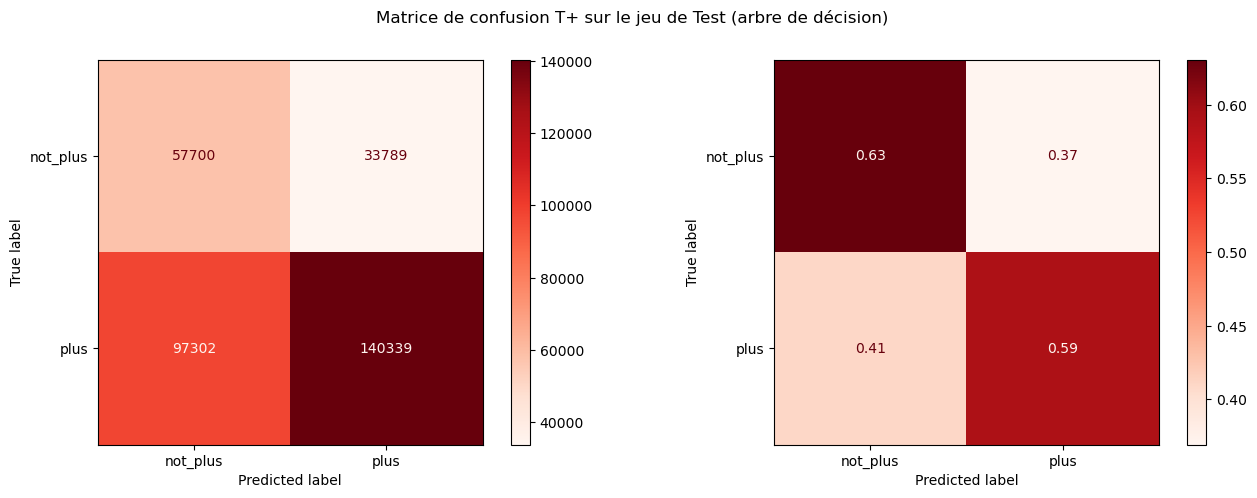

In [204]:
print("----- Arbre de décision T+ -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_train:2.3f}")
print(f"{'AUC':<10s} = {auc_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_test:2.3f}")
print(f"{'AUC':<10s} = {auc_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_test, y_test_pred)
cmatrix_norm = confusion_matrix(y_test, y_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ sur le jeu de Test (arbre de décision)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_cmatrix-dtree-test")

# Show Figure
plt.show()

----- Arbre de décision T+ (with Dist & Angle) -----
Train
Accuracy   = 0.610
AUC        = 0.627
MCC        = 0.228

Test
Accuracy   = 0.605
AUC        = 0.621
MCC        = 0.218


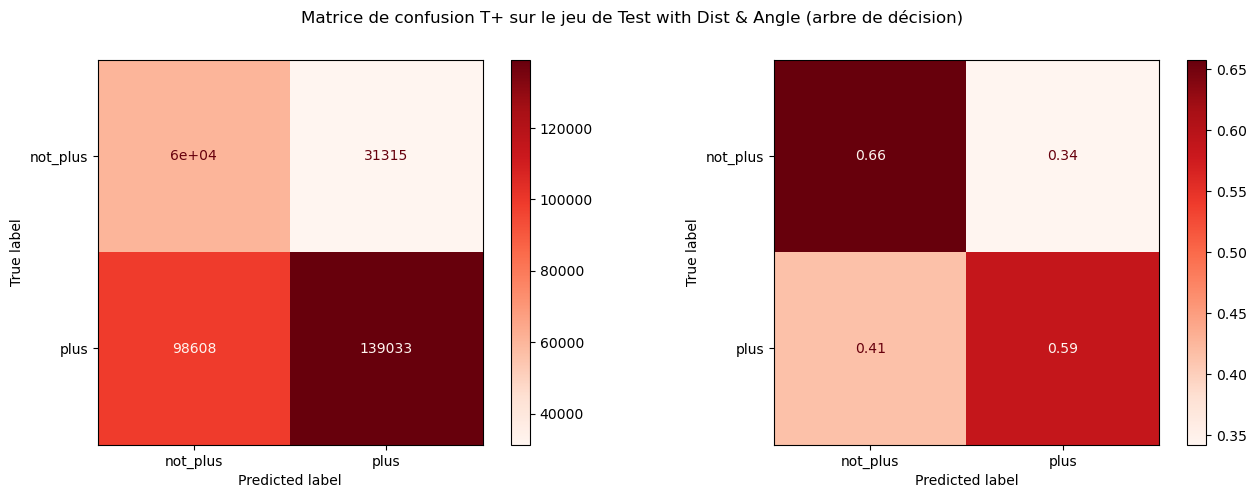

In [205]:
print("----- Arbre de décision T+ (with Dist & Angle) -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_train:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_test:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_test, y_loc_test_pred)
cmatrix_loc_norm = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ sur le jeu de Test with Dist & Angle (arbre de décision)")

# Confusion Matrix displaying count
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

# Confusion Matrix displaying ratio on true label
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_loc-cmatrix-dtree-test")

# Show Figure
plt.show()

In [206]:
# Decision tree text representation
dtree_text = tree.export_text(
    dtree_plus,
    feature_names=x_columns,
    #class_names=dtree_plus.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{plus_tree_dirpath}{sess}_t-plus_text-dtree.txt", "w") as txt:
    txt.write(dtree_text)

# Decision tree plot (too large)
dtree_dot = tree.export_graphviz(
    dtree_plus,
    feature_names=x_columns,
    class_names=dtree_plus.classes_,
    filled=True
)
dtree_dot = plots.node_color(dtree_dot)

dtree_graph = graphviz.Source(dtree_dot, format="png")
dtree_graph.render(f"{plus_tree_dirpath}{sess}_t-plus_dtree")
dtree_graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.181287 to fit


In [207]:
# Decision tree text representation
dtree_loc_text = tree.export_text(
    dtree_loc_plus,
    feature_names=x_loc_columns,
    #class_names=dtree_loc_plus.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{plus_tree_dirpath}{sess}_t-plus_loc-text-dtree.txt", "w") as txt:
    txt.write(dtree_loc_text)

# Decision tree plot (too large)
dtree_loc_dot = tree.export_graphviz(
    dtree_loc_plus,
    feature_names=x_loc_columns,
    class_names=dtree_loc_plus.classes_,
    filled=True
)
dtree_loc_dot = plots.node_color(dtree_loc_dot)

dtree_loc_graph = graphviz.Source(dtree_dot, format="png")
dtree_loc_graph.render(f"{plus_tree_dirpath}{sess}_t-plus_loc-dtree")
dtree_loc_graph

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.181287 to fit


# Random Forest

In [ ]:
depths_rf = [2, 6, 10, 20, 25]

# Results with best selected depth
results_t_plus_rf = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    class_weight="balanced",
    random_state=seed,
    n_estimators = 100,
    n_jobs=-1
)

# Results with best selected depth (with Dist & Angle)
results_loc_t_plus_rf = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    class_weight="balanced",
    random_state=seed,
    n_estimators = 100,
    n_jobs=-1
)

In [ ]:
# Plot - auc
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_plus_rf["auc_train"],
    results_t_plus_rf["auc_test"],
    indices=results_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'AUC selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=0.8, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_plus_rf["auc_train"],
    results_loc_t_plus_rf["auc_test"],
    indices=results_loc_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'AUC (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_loc_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=0.8, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_auc-rforest")

# Showing plot
plt.show()

# Plot - accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_plus_rf["acc_train"],
    results_t_plus_rf["acc_test"],
    indices=results_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'accuracy selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=0.8, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_plus_rf["acc_train"],
    results_loc_t_plus_rf["acc_test"],
    indices=results_loc_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+\n"
          "Evolution de l'accuracy (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_loc_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=0.8, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_accuracy-rforest")

# Showing plot
plt.show()

In [ ]:
print("----- Résumé des performances en classe T plus, random forest -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_plus_rf["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["acc_test"]] ; print("\n")
print(f"{'MCC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["mcc_train"]] ; print()
print(f"{'MCC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_plus_rf["mcc_test"]] ; print("\n")

print("--- with Dist & Angle")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus_rf["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus_rf["acc_test"]] ; print("\n")
print(f"{'MCC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus_rf["mcc_train"]] ; print()
print(f"{'MCC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_plus_rf["mcc_test"]] ; print()

In [ ]:
# Random search parameters
n_estimators_plus = (10, 15, 20, 30)
n_depths_plus = (2, 4, 8, 10, 15)

In [ ]:
# RandomForest model
results_rf_plus = models.perform_random_forest(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    columns=x_columns,
    n_estimators=n_estimators_plus,
    n_depths=n_depths_plus,
    class_weight="balanced",
    scale=False,
    seed=seed
)

# Save MDI importances
df_mdi_rf_plus = pd.DataFrame(
    {
        "mean": results_rf_plus["importance_mdi"]["mean"],
        "std": results_rf_plus["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi_rf_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus_mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_plus = pd.DataFrame(
    {
        "mean": results_rf_plus["importance_permutation"]["mean"],
        "std": results_rf_plus["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation_rf_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus_permu_rforest.csv")  # save

# Model with best parameters
rf_plus = results_rf_plus["model"]

In [ ]:
# RandomForest model with Dist & Angle
results_rf_loc_plus = models.perform_random_forest(
    x_train=x_loc_train,
    x_test=x_loc_test,
    y_train=y_loc_train,
    y_test=y_loc_test,
    columns=x_loc_columns,
    n_estimators=n_estimators_plus,
    n_depths=n_depths_plus,
    class_weight="balanced",
    scale=False,
    seed=seed
)

# Save MDI importances
df_mdi_rf_loc_plus = pd.DataFrame(
    {
        "mean": results_rf_loc_plus["importance_mdi"]["mean"],
        "std": results_rf_loc_plus["importance_mdi"]["std"]
    }, index=x_loc_columns
)

df_mdi_rf_loc_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus_loc-mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_loc_plus = pd.DataFrame(
    {
        "mean": results_rf_loc_plus["importance_permutation"]["mean"],
        "std": results_rf_loc_plus["importance_permutation"]["std"]
    }, index=x_loc_columns
)

df_permutation_rf_loc_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus_loc-permu_rforest.csv")

# Model with best parameters
rf_loc_plus = results_rf_loc_plus["model"]

In [ ]:
# Prediction on train and validation
y_train_pred_rf = rf_plus.predict(x_train)
y_test_pred_rf = rf_plus.predict(x_test)

y_loc_train_pred_rf = rf_loc_plus.predict(x_loc_train)
y_loc_test_pred_rf = rf_loc_plus.predict(x_loc_test)

# Labels
labels_class_plus

In [ ]:
# ROC values - false positive rate (fpr), and true positive rate (tpr)
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_pred_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_pred_rf)

fpr_loc_train_rf, tpr_loc_train_rf, _ = roc_curve(y_loc_train, y_loc_train_pred_rf)
fpr_loc_test_rf, tpr_loc_test_rf, _ = roc_curve(y_loc_test, y_loc_test_pred_rf)

# Model performances, how often is the classifier correct?
# train
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
mcc_train_rf = matthews_corrcoef(y_train, y_train_pred_rf)
auc_train_rf = auc(fpr_train_rf, tpr_train_rf)
# test
acc_test_rf = accuracy_score(y_test, y_test_pred_rf)
mcc_test_rf = matthews_corrcoef(y_test, y_test_pred_rf)
auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

# with dist & angle
# train
acc_loc_train_rf = accuracy_score(y_loc_train, y_loc_train_pred_rf)
mcc_loc_train_rf = matthews_corrcoef(y_loc_train, y_loc_train_pred_rf)
auc_loc_train_rf = auc(fpr_loc_train_rf, tpr_loc_train_rf)
# test
acc_loc_test_rf = accuracy_score(y_loc_test, y_loc_test_pred_rf)
mcc_loc_test_rf = matthews_corrcoef(y_loc_test, y_loc_test_pred_rf)
auc_loc_test_rf = auc(fpr_loc_test_rf, tpr_loc_test_rf)

In [ ]:
print("----- Random Forest T+ -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_test, y_test_pred_rf)
cmatrix_norm = confusion_matrix(y_test, y_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ sur le jeu de Test (randomforest)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_cmatrix-rforest-test")

# Show Figure
plt.show()

In [ ]:
print("----- Random Forest T+ (with Dist & Angle) -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_test, y_loc_test_pred_rf)
cmatrix_loc_norm = confusion_matrix(y_loc_test, y_loc_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ sur le jeu de Test avec Dist & Angle (randomforest)")

# Confusion Matrix displaying count
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

# Confusion Matrix displaying ratio on true label
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_loc-cmatrix-rforest-test")

# Show Figure
plt.show()

# T plus & Density20 > 0

Prédictions des fenêtres avec fibres de classes T+

### Jeu de données d'apprentissage et de validation à densité20 > 0 (sans valeurs aberrantes)

In [ ]:
mask_cd3_density_in = data["Density20"] > 0

In [ ]:
# Target column
y_column = "class_t_plus"

# Define x and y dataframe
xy = data[mask_cd3_density_in][x_loc_columns + [y_column]].dropna()

# features
x_dens = xy[x_columns].values  # x
x_dens_loc = xy[x_loc_columns].values  # x_loc

# target value
y_dens = xy[y_column].values  # y

# Train and Validation set
x_dens_train, x_dens_test, y_dens_train, y_dens_test = train_test_split(
    x_dens, y_dens, test_size=0.3, random_state=seed, stratify=y_dens
)

# Train and Validation set with Angle & Dist
x_loc_dens_train, x_loc_dens_test, y_loc_dens_train, y_loc_dens_test = train_test_split(
    x_dens_loc, y_dens, test_size=0.3, random_state=seed, stratify=y_dens
)

In [ ]:
print(f"----- T plus - density20 > 0 -----")
print(f"\n{'Comptage des classes :':<30s}{'0':<6s}{'':2s}{'1':>6s}")
print(f"{'y:':30s}{sum(y_dens == 0):>6d}{'':2s}{sum(y_dens == 1):>6d}")
print(f"{'y_train:':30s}{sum(y_dens_train == 0):>6d}{'':2s}{sum(y_dens_train == 1):>6d}")
print(f"{'y_test:':30s}{sum(y_dens_test == 0):>6d}{'':2s}{sum(y_dens_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y_dens.shape[0]:_}")

#### Arbre de décision

In [ ]:
depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Results with best selected depth
results_dens_t_plus = models.forest_depth_acc(
    x_dens_train, y_dens_train,
    x_dens_test, y_dens_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced",
)

# Results with best selected depth (with Dist & Angle)
results_loc_dens_t_plus = models.forest_depth_acc(
    x_loc_dens_train, y_loc_dens_train,
    x_loc_dens_test, y_loc_dens_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced",
)

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_dens_t_plus["auc_train"],
    results_dens_t_plus["auc_test"],
    indices=results_dens_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_dens_t_plus["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_plus["auc_train"],
    results_loc_dens_t_plus["auc_test"],
    indices=results_loc_dens_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'AUC avec Dist & Angle selon\n"
          "la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_loc_dens_t_plus["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_auc-decisiontree")

# Showing plot
plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_plus["acc_train"],
    results_dens_t_plus["acc_test"],
    indices=results_dens_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'accuracy en fonction de la "
          "profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_dens_t_plus["depths"], showR2=False, showY=False,
    ybottom=0.45, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_plus["acc_train"],
    results_loc_dens_t_plus["acc_test"],
    indices=results_loc_dens_t_plus["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'accuracy (avec Dist & Angle) en "
          "fonction de\nla profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_loc_dens_t_plus["depths"], showR2=False, showY=False,
    ybottom=0.45, ytop=1, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_accuracy-decisiontree")

# Showing plot
plt.show()

In [ ]:
print("----- Résumé des performances en classe T plus - density, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_dens_t_plus["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus["acc_test"]] ; print("\n")
print(f"{'MCC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus["mcc_train"]] ; print()
print(f"{'MCC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus["mcc_test"]] ; print("\n")

print("--- with Dist & Angle")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus["acc_test"]] ; print("\n")
print(f"{'MCC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus["mcc_train"]] ; print()
print(f"{'MCC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus["mcc_test"]] ; print()

In [ ]:
# Decision Tree (CART)
dtree_dens_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=seed,
    class_weight="balanced",
)

# Decision Tree (CART) with Dist column
dtree_loc_dens_plus = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=seed,
    class_weight="balanced",
)

In [ ]:
# Fitting models to the data
dtree_dens_plus.fit(x_dens_train, y_dens_train)
dtree_loc_dens_plus.fit(x_loc_dens_train, y_loc_dens_train)

# Prediction on train and validation
y_dens_train_pred = dtree_dens_plus.predict(x_dens_train)
y_dens_test_pred = dtree_dens_plus.predict(x_dens_test)

y_loc_dens_train_pred = dtree_loc_dens_plus.predict(x_loc_dens_train)
y_loc_dens_test_pred = dtree_loc_dens_plus.predict(x_loc_dens_test)

# Labels
dtree_dens_plus.classes_ = \
dtree_loc_dens_plus.classes_ = \
labels_class_plus = pd.Series(dtree_dens_plus.classes_).map(
    {0: 'not_plus', 1: 'plus'}
).values

In [ ]:
# Performance
fpr_dens_train, tpr_dens_train, _ = roc_curve(y_dens_train, y_dens_train_pred)
fpr_dens_test, tpr_dens_test, _ = roc_curve(y_dens_test, y_dens_test_pred)

fpr_loc_dens_train, tpr_loc_dens_train, _ = roc_curve(y_loc_dens_train, y_loc_dens_train_pred)
fpr_loc_dens_test, tpr_loc_dens_test, _ = roc_curve(y_loc_dens_test, y_loc_dens_test_pred)

# Model performances, how often is the classifier correct?
# train
acc_dens_train = accuracy_score(y_dens_train, y_dens_train_pred)
mcc_dens_train = matthews_corrcoef(y_dens_train, y_dens_train_pred)
auc_dens_train = auc(fpr_dens_train, tpr_dens_train)
# test
acc_dens_test = accuracy_score(y_dens_test, y_dens_test_pred)
mcc_dens_test = matthews_corrcoef(y_dens_test, y_dens_test_pred)
auc_dens_test = auc(fpr_dens_test, tpr_dens_test)

# with dist & angle
# train
acc_loc_dens_train = accuracy_score(y_loc_dens_train, y_loc_dens_train_pred)
mcc_loc_dens_train = matthews_corrcoef(y_loc_dens_train, y_loc_dens_train_pred)
auc_loc_dens_train = auc(fpr_loc_dens_train, tpr_loc_dens_train)
# test
acc_loc_dens_test = accuracy_score(y_loc_dens_test, y_loc_dens_test_pred)
mcc_loc_dens_test = matthews_corrcoef(y_loc_dens_test, y_loc_dens_test_pred)
auc_loc_dens_test = auc(fpr_loc_dens_test, tpr_loc_dens_test)

In [ ]:
print("----- Arbre de décision - T+ - density20 > 0 -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_dens_train:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_dens_test:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_dens_test, y_dens_test_pred)
cmatrix_norm = confusion_matrix(y_dens_test, y_dens_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ à density20>0 sur le jeu de Test (arbre de décision)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_cmatrix-test")

# Show Figure
plt.show()

In [ ]:
print("----- Arbre de décision - T+ - density20 > 0 (with Dist & Angle) -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_dens_train:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_dens_test:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_dens_test, y_loc_dens_test_pred)
cmatrix_loc_norm = confusion_matrix(y_loc_dens_test, y_loc_dens_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ à density20>0 avec Dist & Angle sur le jeu de Test (arbre de décision)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_loc-cmatrix-test")

# Show Figure
plt.show()

In [ ]:
# Decision tree text representation
dtree_dens_text = tree.export_text(
    dtree_dens_plus,
    feature_names=x_columns,
    #class_names=dtree_dens_plus.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{plus_tree_dirpath}{sess}_t-plus-density_text-dtree.txt", "w") as txt:
    txt.write(dtree_dens_text)

# Decision tree plot (too large)
dtree_dens_dot = tree.export_graphviz(
    dtree_dens_plus,
    feature_names=x_columns,
    class_names=dtree_dens_plus.classes_,
    filled=True
)
dtree_dens_dot = plots.node_color(dtree_dens_dot)

dtree_dens_graph = graphviz.Source(dtree_dens_dot, format="png")
dtree_dens_graph.render(f"{plus_tree_dirpath}{sess}_t-plus-density_dtree")
dtree_dens_graph

In [ ]:
# Decision tree text representation
dtree_loc_dens_text = tree.export_text(
    dtree_loc_dens_plus,
    feature_names=x_loc_columns,
    #class_names=dtree_loc_dens_plus.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{plus_tree_dirpath}{sess}_t-plus-density_loc-text-dtree.txt", "w") as txt:
    txt.write(dtree_loc_dens_text)

# Decision tree plot (too large)
dtree_loc_dens_dot = tree.export_graphviz(
    dtree_loc_dens_plus,
    feature_names=x_loc_columns,
    class_names=dtree_loc_dens_plus.classes_,
    filled=True
)
dtree_loc_dens_dot = plots.node_color(dtree_loc_dens_dot)

dtree_loc_dens_graph = graphviz.Source(dtree_loc_dens_dot, format="png")
dtree_loc_dens_graph.render(f"{plus_tree_dirpath}{sess}_t-plus-density_loc-dtree")
dtree_loc_dens_graph

# Random Forest

In [ ]:
depths_rf = [2, 6, 10, 20, 25]

# Results with best selected depth
results_dens_t_plus_rf = models.forest_depth_acc(
    x_dens_train, y_dens_train,
    x_dens_test, y_dens_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 25,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

# Results with best selected depth (with Dist & Angle)
results_loc_dens_t_plus_rf = models.forest_depth_acc(
    x_loc_dens_train, y_loc_dens_train,
    x_loc_dens_test, y_loc_dens_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 25,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

In [ ]:
# Plot - auc
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_plus_rf["auc_train"],
    results_dens_t_plus_rf["auc_test"],
    indices=results_dens_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'AUC selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_dens_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_plus_rf["auc_train"],
    results_loc_dens_t_plus_rf["auc_test"],
    indices=results_loc_dens_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'AUC (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_loc_dens_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_auc-rforest")

# Showing plot
plt.show()

# Plot - accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_plus_rf["acc_train"],
    results_dens_t_plus_rf["acc_test"],
    indices=results_dens_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'accuracy selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_dens_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.35, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_plus_rf["acc_train"],
    results_loc_dens_t_plus_rf["acc_test"],
    indices=results_loc_dens_t_plus_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T+ - density20>0\n"
          "Evolution de l'accuracy (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_loc_dens_t_plus_rf["depths"], showR2=False, showY=False,
    ybottom=0.35, ytop=1, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_accuracy-rforest")

# Showing plot
plt.show()

In [ ]:
# print("----- Résumé des performances T plus - density20>0, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_dens_t_plus_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_plus_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_plus_rf["acc_test"]] ; print()

In [ ]:
# Random search parameters
n_estimators_dens_plus = (10, 15, 20, 30)
n_depths_dens_plus = (2, 4, 8, 10, 15)

In [ ]:
# Random forest (30, 20)
results_rf_dens_plus = models.perform_random_forest(
    x_train=x_dens_train,
    x_test=x_dens_test,
    y_train=y_dens_train,
    y_test=y_dens_test,
    columns=x_columns,
    n_estimators=n_estimators_dens_plus,
    n_depths=n_depths_dens_plus,
    class_weight="balanced",
    scale=False,
    seed=seed
)

# Save MDI importances
df_mdi_rf_dens_plus = pd.DataFrame(
    {
        "mean": results_rf_dens_plus["importance_mdi"]["mean"],
        "std": results_rf_dens_plus["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi_rf_dens_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus-density_mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_dens_plus = pd.DataFrame(
    {
        "mean": results_rf_dens_plus["importance_permutation"]["mean"],
        "std": results_rf_dens_plus["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation_rf_dens_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus-density_permu_rforest.csv")  # save

# Model with best parameters
rf_dens_plus = results_rf_dens_plus["model"]

In [ ]:
# Random forest with Dist & Angle
results_rf_loc_dens_plus = models.perform_random_forest(
    x_train=x_loc_dens_train,
    x_test=x_loc_dens_test,
    y_train=y_loc_dens_train,
    y_test=y_loc_dens_test,
    columns=x_loc_columns,
    n_estimators=n_estimators_dens_plus,
    n_depths=n_depths_dens_plus,
    class_weight="balanced",
    scale=False,
    seed=seed
)


# Save MDI importances
df_mdi_rf_loc_dens_plus = pd.DataFrame(
    {
        "mean": results_rf_loc_dens_plus["importance_mdi"]["mean"],
        "std": results_rf_loc_dens_plus["importance_mdi"]["std"]
    }, index=x_loc_columns
)

df_mdi_rf_loc_dens_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus-density_loc-mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_loc_dens_plus = pd.DataFrame(
    {
        "mean": results_rf_loc_dens_plus["importance_permutation"]["mean"],
        "std": results_rf_loc_dens_plus["importance_permutation"]["std"]
    }, index=x_loc_columns
)

df_permutation_rf_loc_dens_plus.to_csv(f"{plus_imp_dirpath}{sess}_t-plus-density_loc-permu_rforest.csv")  # save

# Model with best parameters
rf_loc_dens_plus = results_rf_loc_dens_plus["model"]

In [ ]:
# Prediction on train and validation
y_dens_train_pred_rf = rf_dens_plus.predict(x_dens_train)
y_dens_test_pred_rf = rf_dens_plus.predict(x_dens_test)

y_loc_dens_train_pred_rf = rf_loc_dens_plus.predict(x_loc_dens_train)
y_loc_dens_test_pred_rf = rf_loc_dens_plus.predict(x_loc_dens_test)

In [ ]:
# Performance
fpr_dens_train_rf, tpr_dens_train_rf, _ = roc_curve(y_dens_train, y_dens_train_pred_rf)
fpr_dens_test_rf, tpr_dens_test_rf, _ = roc_curve(y_dens_test, y_dens_test_pred_rf)

fpr_loc_dens_train_rf, tpr_loc_dens_train_rf, _ = roc_curve(y_loc_dens_train, y_loc_dens_train_pred_rf)
fpr_loc_dens_test_rf, tpr_loc_dens_test_rf, _ = roc_curve(y_loc_dens_test, y_loc_dens_test_pred_rf)

# Model performances, how often is the classifier correct?
# train
acc_dens_train_rf = accuracy_score(y_dens_train, y_dens_train_pred_rf)
mcc_dens_train_rf = matthews_corrcoef(y_dens_train, y_dens_train_pred_rf)
auc_dens_train_rf = auc(fpr_dens_train_rf, tpr_dens_train_rf)
# test
acc_dens_test_rf = accuracy_score(y_dens_test, y_dens_test_pred_rf)
mcc_dens_test_rf = matthews_corrcoef(y_dens_test, y_dens_test_pred_rf)
auc_dens_test_rf = auc(fpr_dens_test_rf, tpr_dens_test_rf)

# with dist & angle
# train
acc_loc_dens_train_rf = accuracy_score(y_loc_dens_train, y_loc_dens_train_pred_rf)
mcc_loc_dens_train_rf = matthews_corrcoef(y_loc_dens_train, y_loc_dens_train_pred_rf)
auc_loc_dens_train_rf = auc(fpr_loc_dens_train_rf, tpr_loc_dens_train_rf)
# test
acc_loc_dens_test_rf = accuracy_score(y_loc_dens_test, y_loc_dens_test_pred_rf)
mcc_loc_dens_test_rf = matthews_corrcoef(y_loc_dens_test, y_loc_dens_test_pred_rf)
auc_loc_dens_test_rf = auc(fpr_loc_dens_test_rf, tpr_loc_dens_test_rf)

In [ ]:
print("----- Random Forest T+ - density20>0 -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_dens_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_dens_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_dens_test, y_dens_test_pred_rf)
cmatrix_norm = confusion_matrix(y_dens_test, y_dens_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ à density20>0 sur le jeu de Test (randomforest)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_cmatrix-rforest-test")

# Show Figure
plt.show()

In [ ]:
print("----- Random Forest T+ (with Dist & Angle) - density20>0 -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_dens_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_dens_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_dens_test, y_loc_dens_test_pred_rf)
cmatrix_loc_norm = confusion_matrix(y_loc_dens_test, y_loc_dens_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ à density20>0 sur le jeu de Test avec Dist & Angle (randomforest)")

# Confusion Matrix displaying count
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

# Confusion Matrix displaying ratio on true label
ConfusionMatrixDisplay(print("----- Random Forest T+ (with Dist & Angle) -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_test, y_loc_test_pred_rf)
cmatrix_loc_norm = confusion_matrix(y_loc_test, y_loc_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T+ sur le jeu de Test avec Dist & Angle (randomforest)")

# Confusion Matrix displaying count
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_plus,
).plot(ax=ax1, cmap=cmap_color)

# Confusion Matrix displaying ratio on true label
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus_loc-cmatrix-rforest-test")

# Show Figure
plt.show()
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_plus,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{plus_perf_dirpath}{sess}_t-plus-density_loc-cmatrix-rforest-test")

# Show Figure
plt.show()

# T enrichie

Prédiction de fenêtres de classe **enriched**

In [ ]:
# Respective directory for the designed class
enrich_perf_dirpath = auxiliary.create_dir(f"{sess_perf_dirpath}{'enriched'}")
enrich_tree_dirpath = auxiliary.create_dir(f"{sess_tree_dirpath}{'enriched'}")
enrich_imp_dirpath = auxiliary.create_dir(f"{sess_imp_dirpath}{'enriched'}")

### Jeu de données d'apprentissage et de validation (avec valeurs abérrantes)

In [ ]:
# Target column
y_column = "class_t_enriched"

# Define x and y dataframe
xy = data[x_loc_columns + [y_column]].dropna()

# features
x = xy[x_columns].values
x_loc = xy[x_loc_columns].values  # with distance/angle

# target value
y = xy[y_column].values

## Train and Validation
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=seed, stratify=y
)

# With (Angle & Dist)
x_loc_train, x_loc_test, y_loc_train, y_loc_test = train_test_split(
    x_loc, y, test_size=0.3, random_state=seed, stratify=y
)

In [ ]:
print(f"----- T enrichie -----")
print(f"\n{'Comptage des classes :':<30s}{'0':<6s}{'':2s}{'1':>6s}")
print(f"{'y:':30s}{sum(y == 0):>6d}{'':2s}{sum(y == 1):>6d}")
print(f"{'y_train:':30s}{sum(y_train == 0):>6d}{'':2s}{sum(y_train == 1):>6d}")
print(f"{'y_test:':30s}{sum(y_test == 0):>6d}{'':2s}{sum(y_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y.shape[0]:_}")

#### Arbre de décision

In [ ]:
depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Results with best selected depth
results_t_enrich = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced"
)

# Best number of depth with Dist & Angle
results_loc_t_enrich = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced"
)

In [ ]:
# Plot - AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_t_enrich["auc_train"],
    results_t_enrich["auc_test"],
    indices=results_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich["auc_train"],
    results_loc_t_enrich["auc_test"],
    indices=results_loc_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'AUC avec Dist & Angle selon\n"
          "la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched_auc-decisiontree")

# Showing plot
plt.show()

# Plot - Accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enrich["acc_train"],
    results_t_enrich["acc_test"],
    indices=results_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'accuracy en fonction de la "
          "profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich["acc_train"],
    results_loc_t_enrich["acc_test"],
    indices=results_loc_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'accuracy (avec Dist & Angle) en "
          "fonction de\nla profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=depths_dtree, showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-plus_accuracy-decisiontree")

# Showing plot
plt.show()

In [ ]:
print("----- Résumé des performances en classe T enrichie, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enrich["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich["acc_test"]] ; print("\n")
print(f"{'MCC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich["mcc_train"]] ; print()
print(f"{'MCC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich["mcc_test"]] ; print("\n")

print("--- with Dist & Angle")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich["acc_test"]] ; print("\n")
print(f"{'MCC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich["mcc_train"]] ; print()
print(f"{'MCC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich["mcc_test"]] ; print()

In [ ]:
# Decision Tree (CART)
dtree_enriched = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced"
)

# Decision Tree (CART) with Dist column
dtree_loc_enriched = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced"
)

In [ ]:
# Fitting models on data
dtree_enriched.fit(x_train, y_train)
dtree_loc_enriched.fit(x_loc_train, y_loc_train)

# Prediction on train and validation
y_train_pred = dtree_enriched.predict(x_train)
y_test_pred = dtree_enriched.predict(x_test)

y_loc_train_pred = dtree_loc_enriched.predict(x_loc_train)
y_loc_test_pred = dtree_loc_enriched.predict(x_loc_test)

# Labels (for re-assignment)
dtree_enriched.classes_ = \
dtree_loc_enriched.classes_ = \
labels_class_enrich = pd.Series(dtree_enriched.classes_).map(
    {0: 'not_enriched', 1: 'enriched'}
).values

In [ ]:
# ROC values - false positive rate (fpr), and true positive rate (tpr)
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

# Model performances, how often is the classifier correct?
# train
acc_train = accuracy_score(y_train, y_train_pred)
mcc_train = matthews_corrcoef(y_train, y_train_pred)
auc_train = auc(fpr_train, tpr_train)
# test
acc_test = accuracy_score(y_test, y_test_pred)
mcc_test = matthews_corrcoef(y_test, y_test_pred)
auc_test = auc(fpr_test, tpr_test)

# with dist & angle
# train
acc_loc_train = accuracy_score(y_loc_train, y_loc_train_pred)
mcc_loc_train = matthews_corrcoef(y_loc_train, y_loc_train_pred)
auc_loc_train = auc(fpr_loc_train, tpr_loc_train)
# test
acc_loc_test = accuracy_score(y_loc_test, y_loc_test_pred)
mcc_loc_test = matthews_corrcoef(y_loc_test, y_loc_test_pred)
auc_loc_test = auc(fpr_loc_test, tpr_loc_test)

In [ ]:
print("----- Arbre de décision T enrichie -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_train:2.3f}")
print(f"{'AUC':<10s} = {auc_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_test:2.3f}")
print(f"{'AUC':<10s} = {auc_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_test, y_test_pred)
cmatrix_norm = confusion_matrix(y_test, y_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T_enriched sur le jeu de Test (arbre de décision)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched_cmatrix-dtree-test")

# Show Figure
plt.show()

In [ ]:
print("----- Arbre de décision T enrichie (with Dist & Angle) -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_train:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_test:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_test, y_loc_test_pred)
cmatrix_loc_norm = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T_enriched sur le jeu de Test with Dist & Angle (arbre de décision)")

# Confusion Matrix displaying count
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

# Confusion Matrix displaying ratio on true label
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched_loc-cmatrix-dtree-test")

# Show Figure
plt.show()

In [ ]:
# Decision tree text representation
dtree_text = tree.export_text(
    dtree_enriched,
    feature_names=x_columns,
    #class_names=dtree_enriched.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{enrich_tree_dirpath}{sess}_t-enriched_text-dtree.txt", "w") as txt:
    txt.write(dtree_text)

# Decision tree plot (too large)
dtree_dot = tree.export_graphviz(
    dtree_enriched,
    feature_names=x_columns,
    class_names=dtree_enriched.classes_,
    filled=True
)
dtree_dot = plots.node_color(dtree_dot)

dtree_graph = graphviz.Source(dtree_dot, format="png")
dtree_graph.render(f"{enrich_tree_dirpath}{sess}_t-enriched_dtree")
dtree_graph

In [ ]:
# Decision tree text representation
dtree_loc_text = tree.export_text(
    dtree_loc_enriched,
    feature_names=x_loc_columns,
    #class_names=dtree_loc_enriched.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{enrich_tree_dirpath}{sess}_t-enriched_loc-text-dtree.txt", "w") as txt:
    txt.write(dtree_loc_text)

# Decision tree plot (too large)
dtree_loc_dot = tree.export_graphviz(
    dtree_loc_enriched,
    feature_names=x_loc_columns,
    class_names=dtree_loc_enriched.classes_,
    filled=True
)
dtree_loc_dot = plots.node_color(dtree_loc_dot)

dtree_loc_graph = graphviz.Source(dtree_loc_dot, format="png")
dtree_loc_graph.render(f"{enrich_tree_dirpath}{sess}_t-enriched_loc-dtree")
dtree_loc_graph

# Random Forest


In [ ]:
depths_rf = [2, 4, 6, 8, 10, 15, 20]

# Results with best selected depth
results_t_enrich_rf = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

# Results with best selected depth (with Dist & Angle)
results_loc_t_enrich_rf = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

In [ ]:
# Plot - auc
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enrich_rf["auc_train"],
    results_t_enrich_rf["auc_test"],
    indices=results_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'AUC selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich_rf["auc_train"],
    results_loc_t_enrich_rf["auc_test"],
    indices=results_loc_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'AUC (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_loc_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-plus_auc-rforest")

# Showing plot
plt.show()

# Plot - accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enrich_rf["acc_train"],
    results_t_enrich_rf["acc_test"],
    indices=results_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'accuracy selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich_rf["acc_train"],
    results_loc_t_enrich_rf["acc_test"],
    indices=results_loc_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T enriched\n"
          "Evolution de l'accuracy (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_loc_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched_accuracy-rforest")

# Showing plot
plt.show()

In [ ]:
print("----- Résumé des performances en classe T enrichie, random forest -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enrich_rf["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_rf["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_rf["acc_test"]] ; print("\n")
print(f"{'MCC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_rf["mcc_train"]] ; print()
print(f"{'MCC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_rf["mcc_test"]] ; print("\n")

print("--- with Dist & Angle")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_rf["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_rf["acc_test"]] ; print("\n")
print(f"{'MCC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_rf["mcc_train"]] ; print()
print(f"{'MCC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_rf["mcc_test"]] ; print()

In [ ]:
# Random search parameters
n_estimators_enrich = (10, 15, 20, 30)
n_depths_enrich = (2, 4, 8, 10, 15, 18)

In [ ]:
# RandomForest model
results_rf_enrich = models.perform_random_forest(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    columns=x_columns,
    n_estimators=n_estimators_enrich,
    n_depths=n_depths_enrich,
    class_weight="balanced",
    scale=False,
    seed=seed
)

# Save MDI importances
df_mdi_rf_enrich = pd.DataFrame(
    {
        "mean": results_rf_enrich["importance_mdi"]["mean"],
        "std": results_rf_enrich["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi_rf_enrich.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched_mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_enrich = pd.DataFrame(
    {
        "mean": results_rf_enrich["importance_permutation"]["mean"],
        "std": results_rf_enrich["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation_rf_enrich.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched_permu_rforest.csv")  # save

# Model with best parameters
rf_enrich = results_rf_enrich["model"]

In [ ]:
# RandomForest model with Dist & Angle columns
results_rf_loc_enrich = models.perform_random_forest(
    x_train=x_loc_train,
    x_test=x_loc_test,
    y_train=y_loc_train,
    y_test=y_loc_test,
    columns=x_loc_columns,
    n_estimators=n_estimators_enrich,
    n_depths=n_depths_enrich,
    class_weight="balanced",
    scale=False,
    seed=seed
)

# Save MDI importances
df_mdi_rf_loc_enrich = pd.DataFrame(
    {
        "mean": results_rf_loc_enrich["importance_mdi"]["mean"],
        "std": results_rf_loc_enrich["importance_mdi"]["std"]
    }, index=x_loc_columns
)

df_mdi_rf_loc_enrich.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched_loc-mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_loc_plus = pd.DataFrame(
    {
        "mean": results_rf_loc_enrich["importance_permutation"]["mean"],
        "std": results_rf_loc_enrich["importance_permutation"]["std"]
    }, index=x_loc_columns
)

df_permutation_rf_loc_plus.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched_loc-permu_rforest.csv")

# Model with best parameters
rf_loc_enrich = results_rf_loc_enrich["model"]

In [ ]:
# Prediction on train and validation
y_train_pred_rf = rf_enrich.predict(x_train)
y_test_pred_rf = rf_enrich.predict(x_test)

y_loc_train_pred_rf = rf_loc_enrich.predict(x_loc_train)
y_loc_test_pred_rf = rf_loc_enrich.predict(x_loc_test)

# Labels
labels_class_enrich

In [ ]:
# ROC values - false positive rate (fpr), and true positive rate (tpr)
fpr_train_rf, tpr_train_rf, _ = roc_curve(y_train, y_train_pred_rf)
fpr_test_rf, tpr_test_rf, _ = roc_curve(y_test, y_test_pred_rf)

fpr_loc_train_rf, tpr_loc_train_rf, _ = roc_curve(y_loc_train, y_loc_train_pred_rf)
fpr_loc_test_rf, tpr_loc_test_rf, _ = roc_curve(y_loc_test, y_loc_test_pred_rf)

# Model performances, how often is the classifier correct?
# train
acc_train_rf = accuracy_score(y_train, y_train_pred_rf)
mcc_train_rf = matthews_corrcoef(y_train, y_train_pred_rf)
auc_train_rf = auc(fpr_train_rf, tpr_train_rf)
# test
acc_test_rf = accuracy_score(y_test, y_test_pred_rf)
mcc_test_rf = matthews_corrcoef(y_test, y_test_pred_rf)
auc_test_rf = auc(fpr_test_rf, tpr_test_rf)

# with dist & angle
# train
acc_loc_train_rf = accuracy_score(y_loc_train, y_loc_train_pred_rf)
mcc_loc_train_rf = matthews_corrcoef(y_loc_train, y_loc_train_pred_rf)
auc_loc_train_rf = auc(fpr_loc_train_rf, tpr_loc_train_rf)
# test
acc_loc_test_rf = accuracy_score(y_loc_test, y_loc_test_pred_rf)
mcc_loc_test_rf = matthews_corrcoef(y_loc_test, y_loc_test_pred_rf)
auc_loc_test_rf = auc(fpr_loc_test_rf, tpr_loc_test_rf)

In [ ]:
print("----- Random Forest T_enriched -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_test, y_test_pred_rf)
cmatrix_norm = confusion_matrix(y_test, y_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T-enrichie sur le jeu de Test (randomforest)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched_cmatrix-rforest-test")

# Show Figure
plt.show()

In [ ]:
print("----- Random Forest T_enriched (with Dist & Angle) -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_test, y_loc_test_pred_rf)
cmatrix_loc_norm = confusion_matrix(y_loc_test, y_loc_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T-enrichie sur le jeu de Test avec Dist & Angle (randomforest)")

# Confusion Matrix displaying count
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

# Confusion Matrix displaying ratio on true label
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched_loc-cmatrix-rforest-test")

# Show Figure
plt.show()

# T enrichie & Density20 > 0

Prédictions des fenêtres avec fibres de classes T-enrichie

### Jeu de données d'apprentissage et de validation à densité20 > 0 (sans valeurs aberrantes)

In [ ]:
mask_cd3_density_in = data["Density20"] > 0

In [ ]:
# Target column
y_column = "class_t_enriched"

# Define x and y dataframe
xy = data[mask_cd3_density_in][x_loc_columns + [y_column]].dropna()

# features
x_dens = xy[x_columns].values  # x
x_dens_loc = xy[x_loc_columns].values  # x_loc

# target value
y_dens = xy[y_column].values  # y

# Train and Validation set
x_dens_train, x_dens_test, y_dens_train, y_dens_test = train_test_split(
    x_dens, y_dens, test_size=0.3, random_state=seed, stratify=y_dens
)

# Train and Validation set with Angle & Dist
x_loc_dens_train, x_loc_dens_test, y_loc_dens_train, y_loc_dens_test = train_test_split(
    x_dens_loc, y_dens, test_size=0.3, random_state=seed, stratify=y_dens
)

In [ ]:
print(f"----- T enrichie - density20 > 0-----")
print(f"\n{'Comptage des classes :':<30s}{'0':<6s}{'':2s}{'1':>6s}")
print(f"{'y:':30s}{sum(y_dens == 0):>6d}{'':2s}{sum(y_dens == 1):>6d}")
print(f"{'y_train:':30s}{sum(y_dens_train == 0):>6d}{'':2s}{sum(y_dens_train == 1):>6d}")
print(f"{'y_test:':30s}{sum(y_dens_test == 0):>6d}{'':2s}{sum(y_dens_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y_dens.shape[0]:_}")

# Arbre de décision

In [ ]:
depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Results with best selected depth
results_dens_t_enrich = models.forest_depth_acc(
    x_dens_train, y_dens_train,
    x_dens_test, y_dens_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced",
)

# Results with best selected depth (with Dist & Angle)
results_loc_dens_t_enrich = models.forest_depth_acc(
    x_loc_dens_train, y_loc_dens_train,
    x_loc_dens_test, y_loc_dens_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced",
)

In [ ]:
# Plot - AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_dens_t_enrich["auc_train"],
    results_dens_t_enrich["auc_test"],
    indices=results_dens_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_dens_t_enrich["depths"], showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax1),
)

plots.plot(
    results_loc_dens_t_enrich["auc_train"],
    results_loc_dens_t_enrich["auc_test"],
    indices=results_loc_dens_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'AUC avec Dist & Angle selon\n"
          "la profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_loc_dens_t_enrich["depths"], showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched-density_auc-decisiontree")

# Showing plot
plt.show()

# Plot - accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_enrich["acc_train"],
    results_dens_t_enrich["acc_test"],
    indices=results_dens_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'accuracy en fonction de la "
          "profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_dens_t_enrich["depths"], showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_enrich["acc_train"],
    results_loc_dens_t_enrich["acc_test"],
    indices=results_loc_dens_t_enrich["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'accuracy (avec Dist & Angle) en "
          "fonction de\nla profondeur de l'arbre de décision",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_loc_dens_t_enrich["depths"], showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax2),
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched-density_accuracy-decisiontree")

# Showing plot
plt.show()

In [ ]:
print("----- Résumé des performances en classe T enrichie - density, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_dens_t_enrich["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich["acc_test"]] ; print("\n")
print(f"{'MCC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich["mcc_train"]] ; print()
print(f"{'MCC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich["mcc_test"]] ; print("\n")

print("--- with Dist & Angle")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich["acc_test"]] ; print("\n")
print(f"{'MCC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich["mcc_train"]] ; print()
print(f"{'MCC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich["mcc_test"]] ; print()

In [ ]:
# Decision Tree (CART)
dtree_dens_enrich = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced",
)

# Decision Tree (CART) with Dist column
dtree_loc_dens_enrich = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=12,
    random_state=seed,
    class_weight="balanced",
)

In [ ]:
# Fitting models to the data
dtree_dens_enrich.fit(x_dens_train, y_dens_train)
dtree_loc_dens_enrich.fit(x_loc_dens_train, y_loc_dens_train)

# Prediction on train and validation
y_dens_train_pred = dtree_dens_enrich.predict(x_dens_train)
y_dens_test_pred = dtree_dens_enrich.predict(x_dens_test)

y_loc_dens_train_pred = dtree_loc_dens_enrich.predict(x_loc_dens_train)
y_loc_dens_test_pred = dtree_loc_dens_enrich.predict(x_loc_dens_test)

# Labels
dtree_dens_enrich.classes_ = \
dtree_loc_dens_enrich.classes_ = \
labels_class_enrich = pd.Series(dtree_dens_enrich.classes_).map(
    {0: 'not_enriched', 1: 'enriched'}
).values

In [ ]:
# Performance
fpr_dens_train, tpr_dens_train, _ = roc_curve(y_dens_train, y_dens_train_pred)
fpr_dens_test, tpr_dens_test, _ = roc_curve(y_dens_test, y_dens_test_pred)

fpr_loc_dens_train, tpr_loc_dens_train, _ = roc_curve(y_loc_dens_train, y_loc_dens_train_pred)
fpr_loc_dens_test, tpr_loc_dens_test, _ = roc_curve(y_loc_dens_test, y_loc_dens_test_pred)

# Model performances, how often is the classifier correct?
# train
acc_dens_train = accuracy_score(y_dens_train, y_dens_train_pred)
mcc_dens_train = matthews_corrcoef(y_dens_train, y_dens_train_pred)
auc_dens_train = auc(fpr_dens_train, tpr_dens_train)
# test
acc_dens_test = accuracy_score(y_dens_test, y_dens_test_pred)
mcc_dens_test = matthews_corrcoef(y_dens_test, y_dens_test_pred)
auc_dens_test = auc(fpr_dens_test, tpr_dens_test)

# with dist & angle
# train
acc_loc_dens_train = accuracy_score(y_loc_dens_train, y_loc_dens_train_pred)
mcc_loc_dens_train = matthews_corrcoef(y_loc_dens_train, y_loc_dens_train_pred)
auc_loc_dens_train = auc(fpr_loc_dens_train, tpr_loc_dens_train)
# test
acc_loc_dens_test = accuracy_score(y_loc_dens_test, y_loc_dens_test_pred)
mcc_loc_dens_test = matthews_corrcoef(y_loc_dens_test, y_loc_dens_test_pred)
auc_loc_dens_test = auc(fpr_loc_dens_test, tpr_loc_dens_test)

In [ ]:
print("----- Arbre de décision - T_enriched - density20 > 0 -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_dens_train:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_dens_test:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_dens_test, y_dens_test_pred)
cmatrix_norm = confusion_matrix(y_dens_test, y_dens_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T_enriched à density20>0 sur le jeu de Test (arbre de décision)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched-density_cmatrix-test")

# Show Figure
plt.show()

In [ ]:
print("----- Arbre de décision - T_enriched - density20 > 0 (with Dist & Angle) -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_dens_train:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_train:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_train:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_dens_test:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_test:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_test:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_dens_test, y_loc_dens_test_pred)
cmatrix_loc_norm = confusion_matrix(y_loc_dens_test, y_loc_dens_test_pred, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T_enriched à density20>0 avec Dist & Angle sur le jeu de Test (arbre de décision)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched-density_loc-cmatrix-test")

# Show Figure
plt.show()

In [ ]:
# Decision tree text representation
dtree_dens_text = tree.export_text(
    dtree_dens_enrich,
    feature_names=x_columns,
    #class_names=dtree_dens_enrich.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{enrich_tree_dirpath}{sess}_t-enriched-density_text-dtree.txt", "w") as txt:
    txt.write(dtree_dens_text)

# Decision tree plot (too large)
dtree_dens_dot = tree.export_graphviz(
    dtree_dens_enrich,
    feature_names=x_columns,
    class_names=dtree_dens_enrich.classes_,
    filled=True
)
dtree_dens_dot = plots.node_color(dtree_dens_dot)

dtree_dens_graph = graphviz.Source(dtree_dens_dot, format="png")
dtree_dens_graph.render(f"{enrich_tree_dirpath}{sess}_t-enriched-density_dtree")
dtree_dens_graph

In [ ]:
# Decision tree text representation
dtree_loc_dens_text = tree.export_text(
    dtree_loc_dens_enrich,
    feature_names=x_loc_columns,
    #class_names=dtree_loc_dens_enrich.classes_,  # sklearn > 1.3.0
    max_depth=16
)

with open(f"{enrich_tree_dirpath}{sess}_t-enriched-density_loc-text-dtree.txt", "w") as txt:
    txt.write(dtree_loc_dens_text)

# Decision tree plot (too large)
dtree_loc_dens_dot = tree.export_graphviz(
    dtree_loc_dens_enrich,
    feature_names=x_loc_columns,
    class_names=dtree_loc_dens_enrich.classes_,
    filled=True
)
dtree_loc_dens_dot = plots.node_color(dtree_loc_dens_dot)

dtree_loc_dens_graph = graphviz.Source(dtree_loc_dens_dot, format="png")
dtree_loc_dens_graph.render(f"{enrich_tree_dirpath}{sess}_t-enriched-density_loc-dtree")
dtree_loc_dens_graph

# Random Forest

In [ ]:
depths_rf = [2, 6, 10, 15, 20]

# Results with best selected depth
results_dens_t_enrich_rf = models.forest_depth_acc(
    x_dens_train, y_dens_train,
    x_dens_test, y_dens_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 25,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

# Results with best selected depth (with Dist & Angle)
results_loc_dens_t_enrich_rf = models.forest_depth_acc(
    x_loc_dens_train, y_loc_dens_train,
    x_loc_dens_test, y_loc_dens_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 25,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

In [ ]:
# Plot - auc
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_enrich_rf["auc_train"],
    results_dens_t_enrich_rf["auc_test"],
    indices=results_dens_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'AUC selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_dens_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_enrich_rf["auc_train"],
    results_loc_dens_t_enrich_rf["auc_test"],
    indices=results_loc_dens_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'AUC (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="score AUC",
    xticks=results_loc_dens_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.55, ytop=1, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-plus-density_auc-rforest")

# Showing plot
plt.show()

# Plot - accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_enrich_rf["acc_train"],
    results_dens_t_enrich_rf["acc_test"],
    indices=results_dens_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'accuracy selon la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_dens_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_enrich_rf["acc_train"],
    results_loc_dens_t_enrich_rf["acc_test"],
    indices=results_loc_dens_t_enrich_rf["depths"],
    label=("Train", "Test"),
    title=f"{type.upper()} - {condition.upper()} - T_enriched - density20>0\n"
          "Evolution de l'accuracy (avec Dist & Angle) selon\n"
          "la profondeur en RandomForest",
    xlabel="Profondeur de l'arbre", ylabel="Accuracy",
    xticks=results_loc_dens_t_enrich_rf["depths"], showR2=False, showY=False,
    ybottom=0.5, ytop=1, figure=(fig, ax2)
)

# Saving plot
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-plus-density_accuracy-rforest")

# Showing plot
plt.show()

In [ ]:
print("----- Résumé des performances T enrichie - density20>0, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_dens_t_enrich_rf["depths"]] ; print("\n")

print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_rf["auc_test"]] ; print("\n")
print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_rf["acc_test"]] ; print("\n")
print(f"{'MCC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_rf["mcc_train"]] ; print()
print(f"{'MCC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_rf["mcc_test"]] ; print("\n")

print("--- with Dist & Angle")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_rf["auc_test"]] ; print("\n")
print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_rf["acc_test"]] ; print("\n")
print(f"{'MCC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_rf["mcc_train"]] ; print()
print(f"{'MCC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_rf["mcc_test"]] ; print()

In [ ]:
# Random search parameters
n_estimators_dens_enrich = (10, 15, 20, 30)
n_depths_dens_enrich = (2, 4, 8, 10, 15)

In [ ]:
# Random forest
results_rf_dens_enrich = models.perform_random_forest(
    x_train=x_dens_train,
    x_test=x_dens_test,
    y_train=y_dens_train,
    y_test=y_dens_test,
    columns=x_columns,
    n_estimators=n_estimators_dens_enrich,
    n_depths=n_depths_dens_enrich,
    class_weight="balanced",
    scale=False,
    seed=seed
)

# Save MDI importances
df_mdi_rf_dens_enrich = pd.DataFrame(
    {
        "mean": results_rf_dens_enrich["importance_mdi"]["mean"],
        "std": results_rf_dens_enrich["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi_rf_dens_enrich.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched-density_mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_dens_enrich = pd.DataFrame(
    {
        "mean": results_rf_dens_enrich["importance_permutation"]["mean"],
        "std": results_rf_dens_enrich["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation_rf_dens_enrich.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched-density_permu_rforest.csv")  # save

# Model with best parameters
rf_dens_enrich = results_rf_dens_enrich["model"]

In [ ]:
# Random forest with Dist & Angle
results_rf_loc_dens_enrich = models.perform_random_forest(
    x_train=x_loc_dens_train,
    x_test=x_loc_dens_test,
    y_train=y_loc_dens_train,
    y_test=y_loc_dens_test,
    columns=x_loc_columns,
    n_estimators=n_estimators_dens_enrich,
    n_depths=n_depths_dens_enrich,
    class_weight="balanced",
    scale=False,
    seed=seed
)

# Save MDI importances
df_mdi_rf_loc_dens_enrich = pd.DataFrame(
    {
        "mean": results_rf_loc_dens_enrich["importance_mdi"]["mean"],
        "std": results_rf_loc_dens_enrich["importance_mdi"]["std"]
    }, index=x_loc_columns
)

df_mdi_rf_loc_dens_enrich.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched-density_loc-mdi_rforest.csv")  # save

# Save permutation importances
df_permutation_rf_loc_dens_enrich = pd.DataFrame(
    {
        "mean": results_rf_loc_dens_enrich["importance_permutation"]["mean"],
        "std": results_rf_loc_dens_enrich["importance_permutation"]["std"]
    }, index=x_loc_columns
)

df_permutation_rf_loc_dens_enrich.to_csv(f"{enrich_imp_dirpath}{sess}_t-enriched-density_loc-permu_rforest.csv")  # save

# Model with best parameters
rf_loc_dens_enrich = results_rf_loc_dens_enrich["model"]

In [ ]:
# Model Accuracy, how often is the classifier correct?
y_dens_train_pred_rf = rf_dens_enrich.predict(x_dens_train)
y_dens_test_pred_rf = rf_dens_enrich.predict(x_dens_test)

y_loc_dens_train_pred_rf = rf_loc_dens_enrich.predict(x_loc_dens_train)
y_loc_dens_test_pred_rf = rf_loc_dens_enrich.predict(x_loc_dens_test)

In [ ]:
# Performance
fpr_dens_train_rf, tpr_dens_train_rf, _ = roc_curve(y_dens_train, y_dens_train_pred_rf)
fpr_dens_test_rf, tpr_dens_test_rf, _ = roc_curve(y_dens_test, y_dens_test_pred_rf)

fpr_loc_dens_train_rf, tpr_loc_dens_train_rf, _ = roc_curve(y_loc_dens_train, y_loc_dens_train_pred_rf)
fpr_loc_dens_test_rf, tpr_loc_dens_test_rf, _ = roc_curve(y_loc_dens_test, y_loc_dens_test_pred_rf)

# Model performances, how often is the classifier correct?
# train
acc_dens_train_rf = accuracy_score(y_dens_train, y_dens_train_pred_rf)
mcc_dens_train_rf = matthews_corrcoef(y_dens_train, y_dens_train_pred_rf)
auc_dens_train_rf = auc(fpr_dens_train_rf, tpr_dens_train_rf)
# test
acc_dens_test_rf = accuracy_score(y_dens_test, y_dens_test_pred_rf)
mcc_dens_test_rf = matthews_corrcoef(y_dens_test, y_dens_test_pred_rf)
auc_dens_test_rf = auc(fpr_dens_test_rf, tpr_dens_test_rf)

# with dist & angle
# train
acc_loc_dens_train_rf = accuracy_score(y_loc_dens_train, y_loc_dens_train_pred_rf)
mcc_loc_dens_train_rf = matthews_corrcoef(y_loc_dens_train, y_loc_dens_train_pred_rf)
auc_loc_dens_train_rf = auc(fpr_loc_dens_train_rf, tpr_loc_dens_train_rf)
# test
acc_loc_dens_test_rf = accuracy_score(y_loc_dens_test, y_loc_dens_test_pred_rf)
mcc_loc_dens_test_rf = matthews_corrcoef(y_loc_dens_test, y_loc_dens_test_pred_rf)
auc_loc_dens_test_rf = auc(fpr_loc_dens_test_rf, tpr_loc_dens_test_rf)

In [ ]:
print("----- Random Forest T_enriched - density20>0 -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_dens_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_dens_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_dens_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_dens_test_rf:2.3f}")


# Confusion matrix
cmap_color = "Reds"
cmatrix = confusion_matrix(y_dens_test, y_dens_test_pred_rf)
cmatrix_norm = confusion_matrix(y_dens_test, y_dens_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T-enrichie à density20>0 sur le jeu de Test (randomforest)")
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched-density_cmatrix-rforest-test")

# Show Figure
plt.show()

In [ ]:
print("----- Random Forest T_enriched (with Dist & Angle) - density20>0 -----")
print("Train")
print(f"{'Accuracy':<10s} = {acc_loc_dens_train_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_train_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_train_rf:2.3f}")
print()
print("Test")
print(f"{'Accuracy':<10s} = {acc_loc_dens_test_rf:2.3f}")
print(f"{'AUC':<10s} = {auc_loc_dens_test_rf:2.3f}")
print(f"{'MCC':<10s} = {mcc_loc_dens_test_rf:2.3f}")

# Confusion matrix
cmap_color = "Reds"
cmatrix_loc = confusion_matrix(y_loc_test, y_loc_test_pred_rf)
cmatrix_loc_norm = confusion_matrix(y_loc_test, y_loc_test_pred_rf, normalize="true")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
fig.suptitle("Matrice de confusion T_enrichie sur le jeu de Test avec Dist & Angle (randomforest)")

# Confusion Matrix displaying count
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc,
    display_labels=labels_class_enrich,
).plot(ax=ax1, cmap=cmap_color)

# Confusion Matrix displaying ratio on true label
ConfusionMatrixDisplay(
    confusion_matrix=cmatrix_loc_norm,
    display_labels=labels_class_enrich,
).plot(ax=ax2, cmap=cmap_color)

# Save figure
fig.savefig(f"{enrich_perf_dirpath}{sess}_t-enriched-density_loc-cmatrix-rforest-test")

# Show Figure
plt.show()

# T enrichie 2

##### Arbre de décision

In [ ]:
# Respective directory for the designed class
enrich2_perf_dirpath = auxiliary.create_dir(f"{sess_perf_dirpath}{'enriched_2'}")
enrich2_tree_dirpath = auxiliary.create_dir(f"{sess_tree_dirpath}{'enriched_2'}")
enrich2_imp_dirpath = auxiliary.create_dir(f"{sess_imp_dirpath}{'enriched_2'}")

In [ ]:
# Target column
y_column = "class_t_enriched_2"

# Define x and y dataframe
x = data.dropna()[x_columns].values
x_loc = data.dropna()[x_loc_columns].values
y = data.dropna()[y_column].values  # t plus class

# Train and Validation set
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.3, random_state=42, stratify=y
)

# Train and Validation set & (Angle & Dist) (to validate the model)
x_loc_train, x_loc_test, y_loc_train, y_loc_test = train_test_split(
    x_loc, y, test_size=0.3, random_state=42, stratify=y
)

In [ ]:
# print(f"----- T enrichie 2 -----")
print(f"{'Classe :':^45s}{'0':>6s}{'':2s}{'1':>6s}")
print(f"{'Comptage des classes au sein de y:':45s}{sum(y == 0):>6d}{'':2s}{sum(y == 1):>6d}")
print(f"{'Comptage des classes au sein de y_train:':45s}{sum(y_train == 0):>6d}{'':2s}{sum(y_train == 1):>6d}")
print(f"{'Comptage des classes au sein de y_test:':45s}{sum(y_test == 0):>6d}{'':2s}{sum(y_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y.shape[0]:_}")

In [ ]:
# depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Best number of depth
results_t_enrich_2 = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced"
)

# Best number of depth with Dist & Angle
results_loc_t_enrich_2 = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_dtree, 
    classifier=DecisionTreeClassifier,
    random_state=seed,
    class_weight="balanced"
)

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_t_enrich_2["auc_train"],
    results_t_enrich_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.57, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich_2["auc_train"],
    results_loc_t_enrich_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC (avec Dist & Angle) selon\nla profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.57, figure=(fig, ax2)
)
plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enrich_2["acc_train"],
    results_t_enrich_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.50, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich_2["acc_train"],
    results_loc_t_enrich_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.50, figure=(fig, ax2)
)

plt.show()

In [ ]:
# print("----- Résumé des performances T enrichie 2, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enrich_2["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2["acc_test"]] ; print()

In [ ]:
# Decision Tree (CART)
dtree_enriched_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

dtree_enriched_2.fit(x_train, y_train)
y_train_pred = dtree_enriched_2.predict(x_train)
y_test_pred = dtree_enriched_2.predict(x_test)

# Decision Tree (CART) with Dist column
dtree_loc_enriched_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced"
)

dtree_loc_enriched_2.fit(x_loc_train, y_loc_train)
y_loc_train_pred = dtree_loc_enriched_2.predict(x_loc_train)
y_loc_test_pred = dtree_loc_enriched_2.predict(x_loc_test)
dtree_loc_enriched_2

In [ ]:
# fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

In [ ]:
# labels_class = pd.Series(dtree_enriched_2.classes_).map({0: 'not_enriched_2', 1: 'enriched_2'}).values

In [ ]:
# print("----- Arbre de décision -----")
print("Accuracy Train:", accuracy_score(y_train, y_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_test, y_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

In [ ]:
# print("Arbre de décision, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

In [ ]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_enriched_2,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_t-enriched_2")
graph

In [ ]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_loc_enriched_2,
    feature_names=x_loc_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_t-enriched_2_dist")
graph

# Random Forest

In [ ]:
# depths_rf = [2, 4, 6, 8, 10, 15, 20]
results_t_enrich_2_rf = models.forest_depth_acc(
    x_train, y_train, x_test, y_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

results_loc_t_enrich_2_rf = models.forest_depth_acc(
    x_loc_train, y_loc_train, x_loc_test, y_loc_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enrich_2_rf["auc_train"],
    results_t_enrich_2_rf["auc_test"],
    indices=results_t_enrich_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC selon la profondeur des arbres du RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich_2_rf["auc_train"],
    results_loc_t_enrich_2_rf["auc_test"],
    indices=results_loc_t_enrich_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enrichie 2\nEvolution de l'AUC (avec Dist & Angle)\n selon la profondeur des arbres du RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_loc_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_t_enrich_2_rf["acc_train"],
    results_t_enrich_2_rf["acc_test"],
    indices=results_t_enrich_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'accuracy selon la profondeur des arbres du RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax1)
)

plots.plot(
    results_loc_t_enrich_2_rf["acc_train"],
    results_loc_t_enrich_2_rf["acc_test"],
    indices=results_loc_t_enrich_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enrichie 2\nEvolution de l'Accuracy (avec Dist & Angle)\n selon la profondeur des arbres du RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_loc_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax2)
)

plt.show()

In [ ]:
# print("----- Résumé des performances T enrichie, arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_t_enrich_2_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_t_enrich_2_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_t_enrich_2_rf["acc_test"]] ; print()

In [ ]:
# RandomForest model
results_rf_enrich_2 = models.perform_random_forest(
    x_train=x_train,
    x_test=x_test,
    y_train=y_train,
    y_test=y_test,
    columns=x_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False,
    seed=seed
)

rf_enriched_2 = results_rf_enrich_2["model"]

In [ ]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_rf_enrich_2["importance_mdi"]["mean"],
        "std": results_rf_enrich_2["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("KI_CD3_enriched_2_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_rf_enrich_2["importance_permutation"]["mean"],
        "std": results_rf_enrich_2["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("KI_CD3_enriched_2_importance-permutation.csv")

In [ ]:
# RandomForest model with Dist & Angle columns
results_rf_loc_enrich_2 = models.perform_random_forest(
    x_train=x_loc_train,
    x_test=x_loc_test,
    y_train=y_loc_train,
    y_test=y_loc_test,
    columns=x_loc_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False
)

rf_loc_enrich_2 = results_rf_loc_enrich_2["model"]

In [ ]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_rf_loc_enrich_2["importance_mdi"]["mean"],
        "std": results_rf_loc_enrich_2["importance_mdi"]["std"]
    }, index=x_loc_columns
)

df_mdi.to_csv("KI_CD3_enriched_2-dist_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_rf_loc_enrich_2["importance_permutation"]["mean"],
        "std": results_rf_loc_enrich_2["importance_permutation"]["std"]
    }, index=x_loc_columns
)

df_permutation.to_csv("KI_CD3_enriched_2-dist_importance-permutation.csv")

In [ ]:
# Model Accuracy, how often is the classifier correct?
y_train_pred = rf_enriched_2.predict(x_train)
y_test_pred = rf_enriched_2.predict(x_test)
y_loc_train_pred = rf_loc_enrich_2.predict(x_loc_train)
y_loc_test_pred = rf_loc_enrich_2.predict(x_loc_test)

In [ ]:
# fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_train, y_loc_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_test, y_loc_test_pred)

In [ ]:
# labels_class = pd.Series(rf_enriched_2.classes_).map({0: 'not_enriched_2', 1: 'enriched_2'}).values

In [ ]:
# print("----- Random Forest -----")
print("Accuracy Train:", accuracy_score(y_train, y_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_test, y_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_test, y_test_pred)
cm2 = confusion_matrix(y_test, y_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

In [ ]:
# print("Random Forest, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_train, y_loc_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_test, y_loc_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_test, y_loc_test_pred)
cm2_dist = confusion_matrix(y_loc_test, y_loc_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

# T enrichie 2 & Density20 > 0

##### Jeu de données d'apprentissage et de validation (à densité20 > 0)

In [ ]:
# Target column
y_column = "class_t_enriched_2"

# Define x and y dataframe
dt_xy = data[mask_cd3_density_in][[*x_loc_columns, y_column]].dropna()
x_dens = dt_xy[x_columns].values  # x
x_dens_loc = dt_xy[x_loc_columns].values  # x_loc
y_dens = dt_xy[y_column].values  # y

# Train and Validation set
x_dens_train, x_dens_test, y_dens_train, y_dens_test = train_test_split(
    x_dens, y_dens, test_size=0.3, random_state=42, stratify=y_dens
)

# Train and Validation set (with Angle & Dist)
x_loc_dens_train, x_loc_dens_test, y_loc_dens_train, y_loc_dens_test = train_test_split(
    x_dens_loc, y_dens, test_size=0.3, random_state=42, stratify=y_dens
)

In [ ]:
# print(f"----- T enrichie 2 (density20 > 0)-----")
print(f"{'Classe :':^45s}{'0':>6s}{'':2s}{'1':>6s}")
print(f"{'Comptage des classes au sein de y:':45s}{sum(y_dens == 0):>6d}{'':2s}{sum(y_dens == 1):>6d}")
print(f"{'Comptage des classes au sein de y_train:':45s}{sum(y_dens_train == 0):>6d}{'':2s}{sum(y_dens_train == 1):>6d}")
print(f"{'Comptage des classes au sein de y_test:':45s}{sum(y_dens_test == 0):>6d}{'':2s}{sum(y_dens_test == 1):>6d}")
print(f"\nNombre d'observations totales : {y_dens.shape[0]:_}")

# Arbre de décision

In [ ]:
# depths_dtree = [2, 4, 6, 8, 10, 15, 20]

# Best number of depth
results_dens_t_enrich_2 = models.forest_depth_acc(
    x_dens_train, y_dens_train,
    x_dens_test, y_dens_test,
    depths=depths_dtree,
    random_state=seed,
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

# Best number of depth with Dist & Angle
results_loc_dens_t_enrich_2 = models.forest_depth_acc(
    x_loc_dens_train, y_loc_dens_train,
    x_loc_dens_test, y_loc_dens_test,
    depths=depths_dtree,
    random_state=seed,
    classifier=DecisionTreeClassifier,
    class_weight="balanced",
)

In [ ]:
# Plot AUC
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
plots.plot(
    results_dens_t_enrich_2["auc_train"],
    results_dens_t_enrich_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC selon la profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_enrich_2["auc_train"],
    results_loc_dens_t_enrich_2["auc_test"],
    indices=depths_dtree,
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC (avec Dist & Angle) selon\nla profondeur de l'arbre de décision",
    xlabel="AUC score", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.55, figure=(fig, ax2)
)
plt.show()

# Plot accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_enrich_2["acc_train"],
    results_dens_t_enrich_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'accuracy en fonction de la profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.45, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_enrich_2["acc_train"],
    results_loc_dens_t_enrich_2["acc_test"],
    indices=depths_dtree,
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'accuracy (avec Dist & Angle) en fonction de\nla profondeur de l'arbre de décision",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=depths_dtree, showR2=False, showY=False,
    ytop=1, ybottom=0.45, figure=(fig, ax2)
)
plt.show()

In [ ]:
# print("----- Résumé des performances T plus (density20 > 0), arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_dens_t_enrich_2["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2["acc_test"]] ; print()

In [ ]:
# Decision Tree (CART)
dtree_dens_enrich_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_dens_enrich_2.fit(x_dens_train, y_dens_train)
y_dens_train_pred = dtree_dens_enrich_2.predict(x_dens_train)
y_dens_test_pred = dtree_dens_enrich_2.predict(x_dens_test)

# Decision Tree (CART) with Dist column
dtree_loc_dens_enrich_2 = DecisionTreeClassifier(
    criterion="entropy",
    max_depth=10,
    random_state=42,
    class_weight="balanced",
)

dtree_loc_dens_enrich_2.fit(x_loc_dens_train, y_loc_dens_train)
y_loc_dens_train_pred = dtree_loc_dens_enrich_2.predict(x_loc_dens_train)
y_loc_dens_test_pred = dtree_loc_dens_enrich_2.predict(x_loc_dens_test)

# Performance
fpr_train, tpr_train, _ = roc_curve(y_dens_train, y_dens_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_dens_test, y_dens_test_pred)

fpr_loc_train, tpr_loc_train, _ = roc_curve(y_loc_dens_train, y_loc_dens_train_pred)
fpr_loc_test, tpr_loc_test, _ = roc_curve(y_loc_dens_test, y_loc_dens_test_pred)

In [ ]:
# labels_class = pd.Series(dtree_dens_enrich_2.classes_).map({0: 'not_enriched_2', 1: 'enriched_2'}).values

In [ ]:
# Model Accuracy, how often is the classifier correct?
print("----- Arbre de décision (density20 > 0) -----")
print("Accuracy Train:", accuracy_score(y_dens_train, y_dens_train_pred))
print("AUC Train:", auc(fpr_train, tpr_train))
print()
print("Accuracy Test:", accuracy_score(y_dens_test, y_dens_test_pred))
print("AUC Test:", auc(fpr_test, tpr_test))
print()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm = confusion_matrix(y_dens_test, y_dens_test_pred)
cm2 = confusion_matrix(y_dens_test, y_dens_test_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=labels_class).plot(ax=ax2)
plt.show()

In [ ]:
# print("Arbre de décision acc, Angle avec Dist")
print("Accuracy Train:", accuracy_score(y_loc_dens_train, y_loc_dens_train_pred))
print("AUC Train:", auc(fpr_loc_train, tpr_loc_train))
print()
print("Accuracy Test:", accuracy_score(y_loc_dens_test, y_loc_dens_test_pred))
print("AUC Test:", auc(fpr_loc_test, tpr_loc_test))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
cm_dist = confusion_matrix(y_loc_dens_train, y_loc_dens_train_pred)
cm2_dist = confusion_matrix(y_loc_dens_train, y_loc_dens_train_pred, normalize="true")
ConfusionMatrixDisplay(confusion_matrix=cm_dist, display_labels=labels_class).plot(ax=ax1)
ConfusionMatrixDisplay(confusion_matrix=cm2_dist, display_labels=labels_class).plot(ax=ax2)
plt.show()

In [ ]:
# Arbre de Décision
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_dens_enrich_2,
    feature_names=x_columns,
    class_names=labels_class,
    filled=True
)
graph = graphviz.Source(dot_data, format="png")
#graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

In [ ]:
# Arbre de décision avec l'ajout de Dist & Angle
fig = plt.figure(figsize=(10, 30))
dot_data = tree.export_graphviz(
    dtree_loc_dens_enrich_2,
    feature_names=x_loc_columns,
    class_names=labels_class,
    filled=True
)

graph = graphviz.Source(dot_data, format="png")
graph.render("../out/KI_decision_tree_density_t-plus_dist")
graph

# Random Forest

In [ ]:
# depths_rf = [2, 6, 10, 15, 20]
results_dens_t_enrich_2_rf = models.forest_depth_acc(
    x_dens_train, y_dens_train,
    x_dens_test, y_dens_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

results_loc_dens_t_enrich_2_rf = models.forest_depth_acc(
    x_loc_dens_train, y_loc_dens_train,
    x_loc_dens_test, y_loc_dens_test,
    depths=depths_rf, 
    classifier=RandomForestClassifier,
    n_estimators = 100,
    random_state=seed,
    class_weight="balanced",
    n_jobs=-1
)

In [ ]:
# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_enrich_2_rf["auc_train"],
    results_dens_t_enrich_2_rf["auc_test"],
    indices=results_dens_t_enrich_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_dens_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_enrich_2_rf["auc_train"],
    results_loc_dens_t_enrich_2_rf["auc_test"],
    indices=results_loc_dens_t_enrich_2_rf["depths"],
    label=("Train AUC", "Test AUC"),
    title="T enriched 2 density\nEvolution de l'AUC (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="AUC", ylabel="Profondeur de l'arbre",
    xticks=results_loc_dens_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.58, figure=(fig, ax2)
)

plt.show()

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

plots.plot(
    results_dens_t_enrich_2_rf["acc_train"],
    results_dens_t_enrich_2_rf["acc_test"],
    indices=results_dens_t_enrich_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'accuracy selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_dens_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax1)
)

plots.plot(
    results_loc_dens_t_enrich_2_rf["acc_train"],
    results_loc_dens_t_enrich_2_rf["acc_test"],
    indices=results_loc_dens_t_enrich_2_rf["depths"],
    label=("Train Accuracy", "Test Accuracy"),
    title="T enriched 2 density\nEvolution de l'Accuracy (avec Dist & Angle) selon la profondeur des arbres\ndu RandomForest",
    xlabel="Accuracy", ylabel="Profondeur de l'arbre",
    xticks=results_loc_dens_t_enrich_2_rf["depths"], showR2=False, showY=False,
    ytop=1, ybottom=0.65, figure=(fig, ax2)
)

plt.show()

In [ ]:
# print("----- Résumé des performances T plus (density20 > 0), arbre de décision -----")
print(f"{'Profondeur':<20s}:", end=" ") ; [print(f"{i:<4d}", end="  ") for i in results_dens_t_enrich_2_rf["depths"]] ; print("\n")
print(f"{'AUC_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2_rf["auc_train"]] ; print()
print(f"{'AUC_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_dens_t_enrich_2_rf["acc_test"]] ; print("\n")

print("---")
print(f"{'AUC_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2_rf["auc_train"]] ; print()
print(f"{'AUC_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2_rf["auc_test"]] ; print("\n")

print(f"{'Accuracy_train_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2_rf["acc_train"]] ; print()
print(f"{'Accuracy_test_dist':<20s}:", end=" ") ; [print(f"{i:<.2f}", end="  ") for i in results_loc_dens_t_enrich_2_rf["acc_test"]] ; print()

In [ ]:
# RandomForest model
results_rf_dens_enrich_2 = models.perform_random_forest(
    x_train=x_dens_train,
    x_test=x_dens_test,
    y_train=y_dens_train,
    y_test=y_dens_test,
    columns=x_columns,
    n_estimators=(10, 15, 20, 30),
    n_depths=(2, 4, 8, 10, 15),
    class_weight="balanced",
    scale=False,
    seed=seed
)

rf_dens_enrich_2 = results_rf_dens_enrich_2["model"]

In [ ]:
# df_mdi = pd.DataFrame(
    {
        "mean": results_rf_dens_plus["importance_mdi"]["mean"],
        "std": results_rf_dens_plus["importance_mdi"]["std"]
    }, index=x_columns
)

df_mdi.to_csv("WT_CD3_t-plus_density_importance-mdi.csv")

df_permutation = pd.DataFrame(
    {
        "mean": results_rf_dens_plus["importance_permutation"]["mean"],
        "std": results_rf_dens_plus["importance_permutation"]["std"]
    }, index=x_columns
)

df_permutation.to_csv("WT_CD3_t-plus_density_importance-permutation.csv")